In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary 

In [2]:
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\RIPPLE\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_dir = 'data/train_data'
test_dir = 'data/test_data'
diseases = os.listdir(train_dir)
train_dir, test_dir

('data/train_data', 'data/test_data')

In [5]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [6]:
# plants = []
# NumberOfDiseases = 0
# for plant in diseases:
#     if plant.split('___')[0] not in plants:
#         plants.append(plant.split('___')[0])
#     if plant.split('___')[1] != 'healthy':
#         NumberOfDiseases += 1

In [7]:
print(f"Unique Plants are: \n{plants}")

# number of unique plants
print("Number of plants: {}".format(len(plants)))

# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Unique Plants are: 
['Potato', 'Tomato']
Number of plants: 2
Number of diseases: 11


In [8]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Potato___Early_blight,1939
Potato___healthy,1824
Potato___Late_blight,1939
Tomato___Bacterial_spot,1702
Tomato___Early_blight,1920
Tomato___healthy,1926
Tomato___Late_blight,1851
Tomato___Leaf_Mold,1882
Tomato___Septoria_leaf_spot,1745
Tomato___Spider_mites Two-spotted_spider_mite,1741


Text(0.5, 1.0, 'Images per each class of plant disease')

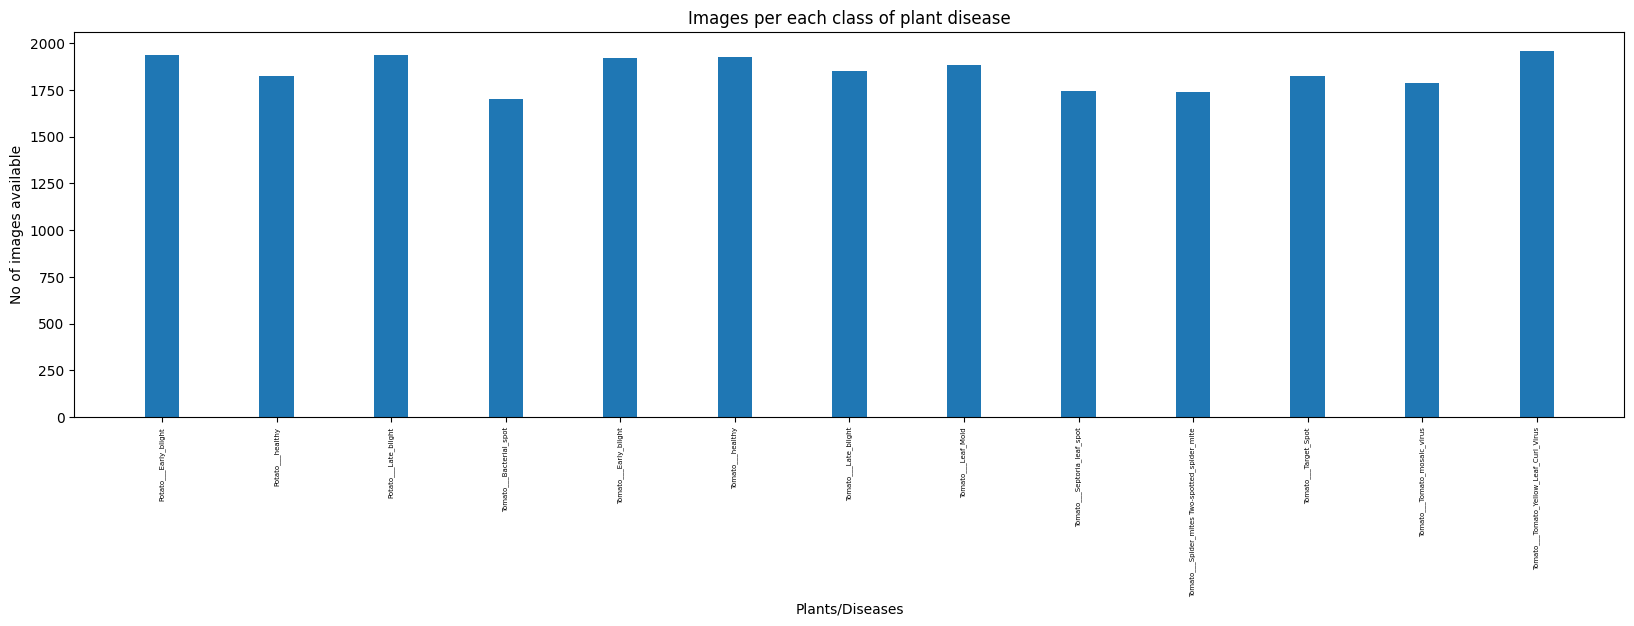

In [9]:
index = [n for n in range(13)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [10]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 24047 images for training


In [11]:

from torch.utils.data import DataLoader, WeightedRandomSampler

In [12]:
# from torchvision import transforms
# from PIL import Image
# import random

# def custom_transforms(img, probability=0.2):
#     # Color Augmentation
#     if random.random() < probability:
#         img = transforms.ColorJitter(saturation=0.2, hue=0.2, contrast=0.2)(img)

#     # Histogram Equalization
#     if random.random() < probability:
#         img = transforms.functional.equalize(img)

#     # Gaussian Blur
#     if random.random() < probability:
#         img = transforms.GaussianBlur(kernel_size=3)(img)

#     # # Add Noise (Random Erasing for noise)
#     # if random.random() < probability:
#     #     img = transforms.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3))(img)

#     # Random Scaling and Rotation
#     if random.random() < probability:
#         scale_factor = random.uniform(0.95, 1.05)
#         angle = random.uniform(-30, 30)
#         img = transforms.functional.affine(img, angle=angle, translate=(0, 0), scale=scale_factor, shear=0)

#     # Position Augmentation
#     if random.random() < probability:
#         angles = [45, 135, 225, 315]
#         angle = random.choice(angles)
#         img = transforms.functional.affine(img, angle=angle, translate=(0, 0), scale=1, shear=0)

#     # Horizontal Flip
#     if random.random() < probability:
#         img = transforms.functional.hflip(img)

#     # Vertical Flip
#     if random.random() < probability:
#         img = transforms.functional.vflip(img)

#     return img

# composed_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     lambda img: custom_transforms(img, probability=0.01),  # Adjust probability as needed
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [13]:
# Define transformations
composed_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [41]:
# # Define transformations
# composed_transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

In [16]:
dataset = ImageFolder(root=train_dir, transform=composed_transform)
test_dataset = ImageFolder(root=test_dir, transform=composed_transform)

In [15]:

# Calculate class weights for WeightedRandomSampler
class_counts = [0] * len(dataset.classes)
for _, label in dataset.samples:
    class_counts[label] += 1

total_samples = float(len(dataset))
class_weights = [total_samples / (len(dataset.classes) * count) for count in class_counts]
weights = [class_weights[cls] for _, cls in dataset.samples]

weights


[0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,
 0.953981037013528,


In [14]:
# Create a weighted sampler to handle class imbalance
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
sampler.weights.count_nonzero()
sampler.weights


NameError: name 'weights' is not defined

In [17]:
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, pin_memory=True)

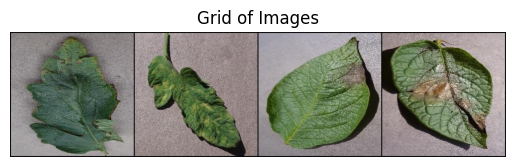

In [50]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


torch.manual_seed(42)
# Assuming you have a DataLoader named train_loader
# Make sure to replace YourDatasetClass with your actual dataset class
# and transform with your actual image transformations
from torchvision.transforms import ToPILImage

# Set the device to 'cuda' if available, otherwise 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fetch a batch of images from the DataLoader
images, _ = next(iter(train_dataloader))

# Move images to the CPU for visualization (if on GPU)
images = images.to(device)

# Create a grid of images
grid_image = make_grid(images, nrow=4)  # You can adjust nrow as needed

# Convert the grid image from a tensor to a PIL Image
to_pil = ToPILImage()
pil_image = to_pil(grid_image)

# Display the entire grid using Matplotlib
plt.imshow(pil_image)
plt.title('Grid of Images')
plt.axis('off')
plt.show()


In [18]:
# Setup DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=composed_transform,
                                                                                                 batch_size=32)

In [19]:
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [18]:
# Assuming PyTorch is already imported and your DataLoader is named train_dataloader
import torch

# Retrieve a batch of data
images, _ = next(iter(train_dataloader))

# Print the shape of the images tensor
print(images.shape)


torch.Size([32, 3, 224, 224])


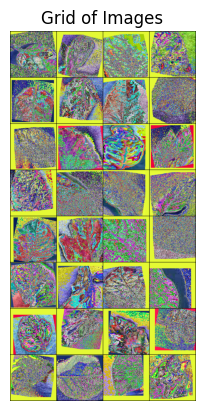

In [19]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

# Assuming you have a DataLoader named train_loader
# Make sure to replace YourDatasetClass with your actual dataset class
# and transform with your actual image transformations
from torchvision.transforms import ToPILImage

# Set the device to 'cuda' if available, otherwise 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fetch a batch of images from the DataLoader
images, _ = next(iter(train_dataloader))

# Move images to the CPU for visualization (if on GPU)
images = images.to(device)

# Create a grid of images
grid_image = make_grid(images, nrow=4)  # You can adjust nrow as needed

# Convert the grid image from a tensor to a PIL Image
to_pil = ToPILImage()
pil_image = to_pil(grid_image)

# Display the entire grid using Matplotlib
plt.imshow(pil_image)
plt.title('Grid of Images')
plt.axis('off')
plt.show()


In [20]:
# Create a DataLoader using the weighted sampler
train_dataloader = DataLoader(dataset, batch_size=32, sampler=sampler, num_workers=os.cpu_count(), pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)



In [20]:
import torch
import torch.nn as nn

# Define BasicBlock for ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection if the input and output dimensions do not match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# Define the ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes=13):  # Set num_classes to 13
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.in_channels = 64  # Initialize in_channels
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, channels, num_blocks, stride):
        layers = [block(self.in_channels, channels, stride)]
        self.in_channels = channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Example usage:
model = ResNet18(num_classes=13).to(device)  # Specify 13 classes for classification
example_input = torch.randn((1, 3, 224, 224)).to(device)  # Example input tensor
# output = resnet18_model(example_input)
# print(output.shape)  # Check the shape of the output


In [19]:
import torch
import torch.nn as nn

# Define BasicBlock for ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection if the input and output dimensions do not match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# Define the ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes=13, dropout_prob=0.1):  # Set num_classes to 13
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.in_channels = 64  # Initialize in_channels
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def _make_layer(self, block, channels, num_blocks, stride):
        layers = [block(self.in_channels, channels, stride)]
        self.in_channels = channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # x = self.dropout(x)
        x = self.fc(x)

        return x

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=13, dropout_prob=0.1).to(device)  # Specify 13 classes for classification and dropout probability
example_input = torch.randn((1, 3, 224, 224)).to(device)  # Example input tensor
# output = model(example_input)
# print(output.shape)  # Check the shape of the output


In [20]:
# Set up optimizer and learning rate scheduler
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [21]:

import torch.optim as optim


In [22]:
model.parameters

<bound method Module.parameters of ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [23]:

optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dataloader), epochs=10)

In [24]:
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
set_seeds()
resnet_results = engine.train(model=model,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                epochs=20,
                                optimizer=optimizer,
                                # scheduler=scheduler,
                                loss_fn=loss_fn,
                                device=device)

  5%|▌         | 1/20 [06:02<1:54:38, 362.05s/it]

Epoch: 1 | train_loss: 1.9341 | train_acc: 0.3529 | test_loss: 1.9165 | test_acc: 0.3974


 10%|█         | 2/20 [12:03<1:48:32, 361.79s/it]

Epoch: 2 | train_loss: 1.4696 | train_acc: 0.5090 | test_loss: 1.6113 | test_acc: 0.4802


 15%|█▌        | 3/20 [16:19<1:28:46, 313.35s/it]

Epoch: 3 | train_loss: 1.2515 | train_acc: 0.5808 | test_loss: 2.1061 | test_acc: 0.4510


 20%|██        | 4/20 [19:49<1:12:40, 272.51s/it]

Epoch: 4 | train_loss: 1.0442 | train_acc: 0.6510 | test_loss: 1.5250 | test_acc: 0.5164


 20%|██        | 4/20 [22:08<1:28:35, 332.21s/it]


KeyboardInterrupt: 

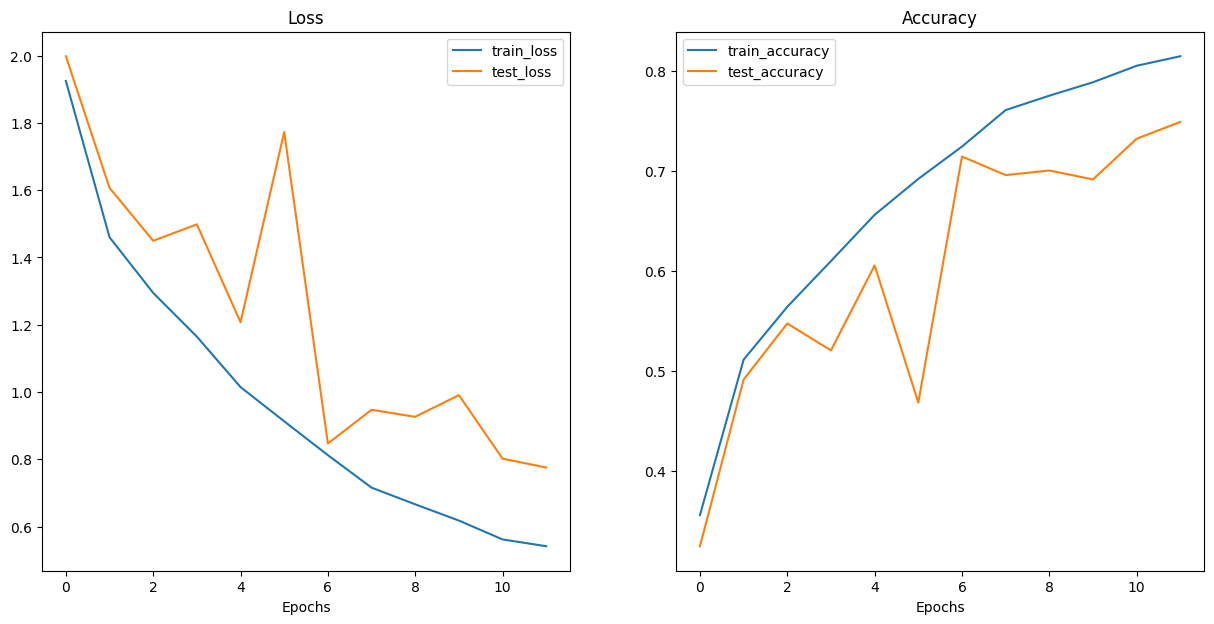

In [34]:
from helper_functions import plot_loss_curves

plot_loss_curves(resnet_results)

In [38]:
result_df = pd.DataFrame(resnet_results)
result_df
result_df.to_csv('output.csv', index=False)

In [40]:
df = pd.read_csv('output.csv')
df

,train_loss,train_acc,test_loss,test_acc
0,1.924702,0.355856,1.998167,0.324709
1,1.459913,0.511179,1.606771,0.491274
2,1.294500,0.564042,1.449473,0.547358
3,1.164457,0.609748,1.498302,0.520442
4,1.014484,0.655963,1.207188,0.605372
5,0.912728,0.691884,1.772844,0.468315
6,0.812099,0.724188,0.846764,0.714226
7,0.715538,0.760659,0.947019,0.695677
8,0.665885,0.775057,0.926064,0.700257
9,0.617657,0.788480,0.990640,0.691361


In [46]:
from going_modular import utils

# Save the model
utils.save_model(model=model,
                 target_dir="models",
                 model_name="resnet_18.pth")

[INFO] Saving model to: models\resnet_18.pth


In [ ]:
import torch

# Specify the path to your .pth file
model_path = './models/resnet_18_20_epoch.pth'

# Load the model
model = torch.load(model_path)

# If you want to load the model state dictionary only (without the architecture)
# state_dict = torch.load(model_path)
# your_model.load_state_dict(state_dict)

# Now you can use the loaded_model for inference or further training


In [33]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
resnet_model_size = Path("models/resnet_18.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Our resnet18 model size: {resnet_model_size} MB")

Our resnet18 model size: 42 MB


<bound method Module.state_dict of ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [28]:
resnet_total_params = sum(torch.numel(param) for param in model.parameters())
resnet_total_params

AttributeError: 'collections.OrderedDict' object has no attribute 'parameters'

In [48]:
resnet18_stats = {"test_loss": resnet_results["test_loss"][-1],
                  "test_acc": resnet_results["test_acc"][-1],
                  "number_of_parameters": resnet_total_params,
                  "model_size (MB)": pretrained_resnet_model_size}
resnet18_stats

NameError: name 'resnet_results' is not defined

In [30]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/test_data


[WindowsPath('data/test_data/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG'),
 WindowsPath('data/test_data/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG'),
 WindowsPath('data/test_data/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136_180deg.JPG'),
 WindowsPath('data/test_data/Potato___Early_blight/044c3abc-0bc9-45fb-8fd5-094aeb605f90___RS_Early.B 8044_180deg.JPG'),
 WindowsPath('data/test_data/Potato___Early_blight/048d18ae-98b1-484d-97da-5a0e69b9ebc1___RS_Early.B 6845.JPG')]

In [31]:
import pathlib
import torch
import torchvision

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [32]:
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [33]:
import torch
import torchvision.models as models

# Assume 'your_model_class' is the class of your model
# Example: your_model_class = YourModelClass()

# Load the model state dictionary
model_state_dict = torch.load('./models/resnet_18.pth')

# Create an instance of the model
model = ResNet18()

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

# Move the model to the desired device (e.g., GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Now, your_model_instance is ready for inference or further training


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [34]:
# Make predictions across test dataset with Resnet
resnet_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=model,
                                          transform=composed_transform,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

100%|██████████| 6011/6011 [13:54<00:00,  7.20it/s]


In [35]:
test_df = pd.DataFrame(resnet_test_pred_dicts)
test_df
test_df.to_csv('test_result.csv', index=False)
test_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\test_data\Potato___Early_blight\002a55fb-...,Potato___Early_blight,0.7898,Potato___Early_blight,0.1912,True
1,data\test_data\Potato___Early_blight\00d8f10f-...,Potato___Early_blight,0.7864,Potato___Early_blight,0.0842,True
2,data\test_data\Potato___Early_blight\034959c1-...,Potato___Early_blight,0.9656,Potato___Early_blight,0.0769,True
3,data\test_data\Potato___Early_blight\044c3abc-...,Potato___Early_blight,0.9280,Tomato___Septoria_leaf_spot,0.0562,False
4,data\test_data\Potato___Early_blight\048d18ae-...,Potato___Early_blight,0.5994,Potato___Early_blight,0.0683,True


In [36]:
resnet_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/test_data/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG'),
  'class_name': 'Potato___Early_blight',
  'pred_prob': 0.7898,
  'pred_class': 'Potato___Early_blight',
  'time_for_pred': 0.1912,
  'correct': True},
 {'image_path': WindowsPath('data/test_data/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG'),
  'class_name': 'Potato___Early_blight',
  'pred_prob': 0.7864,
  'pred_class': 'Potato___Early_blight',
  'time_for_pred': 0.0842,
  'correct': True}]

In [37]:
import pandas as pd
resnet_test_pred_df = pd.DataFrame(resnet_test_pred_dicts)
resnet_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\test_data\Potato___Early_blight\002a55fb-...,Potato___Early_blight,0.7898,Potato___Early_blight,0.1912,True
1,data\test_data\Potato___Early_blight\00d8f10f-...,Potato___Early_blight,0.7864,Potato___Early_blight,0.0842,True
2,data\test_data\Potato___Early_blight\034959c1-...,Potato___Early_blight,0.9656,Potato___Early_blight,0.0769,True
3,data\test_data\Potato___Early_blight\044c3abc-...,Potato___Early_blight,0.9280,Tomato___Septoria_leaf_spot,0.0562,False
4,data\test_data\Potato___Early_blight\048d18ae-...,Potato___Early_blight,0.5994,Potato___Early_blight,0.0683,True


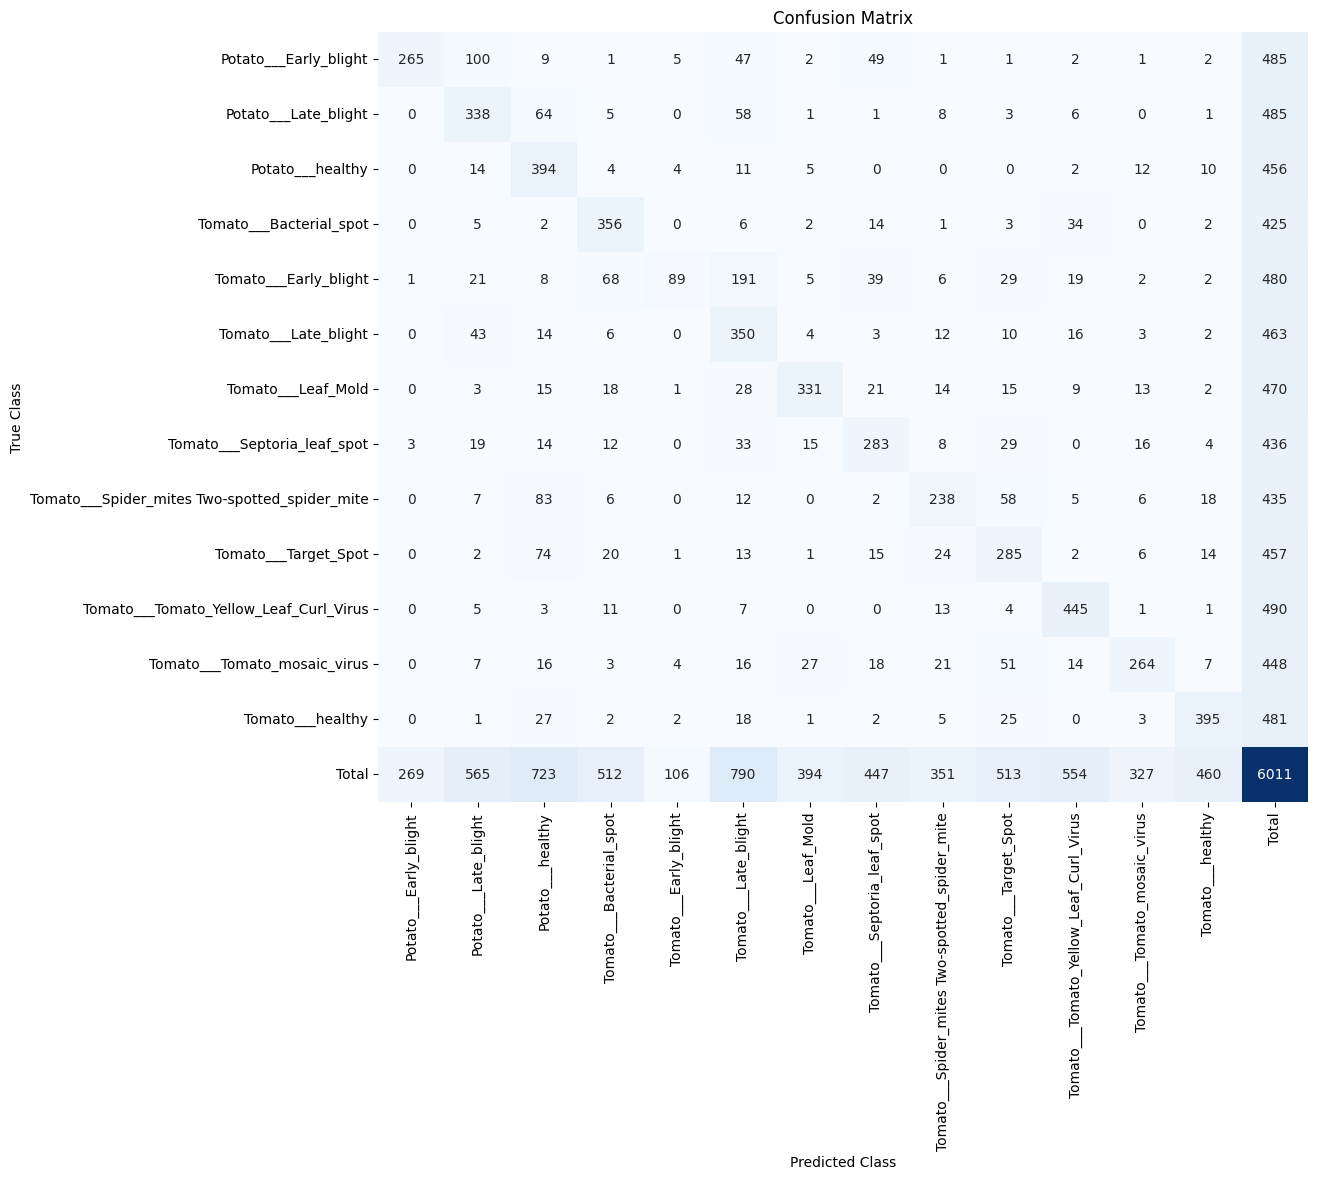

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'resnet_test_pred_df' is your DataFrame
# Example:
# resnet_test_pred_df = pd.DataFrame({'image_path': ..., 'class_name': ..., 'pred_prob': ..., 'pred_class': ..., 'time_for_pred': ..., 'correct': ...})

# Create a confusion matrix
conf_matrix = pd.crosstab(resnet_test_pred_df['class_name'], resnet_test_pred_df['pred_class'], margins=True, margins_name='Total')

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming you have a DataFrame named resnet_test_pred_df
actual_labels = resnet_test_pred_df['class_name']
predicted_labels = resnet_test_pred_df['pred_class']

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=class_names)

# Calculate metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print the confusion matrix and metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[265 100   9   1   5  47   2  49   1   1   2   1   2]
 [  0 338  64   5   0  58   1   1   8   3   6   0   1]
 [  0  14 394   4   4  11   5   0   0   0   2  12  10]
 [  0   5   2 356   0   6   2  14   1   3  34   0   2]
 [  1  21   8  68  89 191   5  39   6  29  19   2   2]
 [  0  43  14   6   0 350   4   3  12  10  16   3   2]
 [  0   3  15  18   1  28 331  21  14  15   9  13   2]
 [  3  19  14  12   0  33  15 283   8  29   0  16   4]
 [  0   7  83   6   0  12   0   2 238  58   5   6  18]
 [  0   2  74  20   1  13   1  15  24 285   2   6  14]
 [  0   5   3  11   0   7   0   0  13   4 445   1   1]
 [  0   7  16   3   4  16  27  18  21  51  14 264   7]
 [  0   1  27   2   2  18   1   2   5  25   0   3 395]]

Metrics:
Accuracy: 0.6709
Precision: 0.7167
Recall: 0.6709
F1 Score: 0.6627


In [40]:
resnet_test_pred_df.correct.value_counts()

correct
True     4033
False    1978
Name: count, dtype: int64

In [41]:
# Put resnet on CPU
model.to("cpu") 

# Check the device
next(iter(model.parameters())).device

device(type='cpu')

In [42]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    %pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

Gradio version: 4.15.0


In [43]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = composed_transform(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [44]:
import random
from PIL import Image
from pathlib import Path

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data\test_data\Potato___Early_blight\cff1ed1b-51ec-4d44-ab1f-7a3dc1ec9ea9___RS_Early.B 7100_180deg.JPG

Prediction label and probability dictionary: 
{'Potato___Early_blight': 0.7775909304618835, 'Potato___Late_blight': 0.21456943452358246, 'Potato___healthy': 1.2526619457275956e-06, 'Tomato___Bacterial_spot': 3.61060920113232e-05, 'Tomato___Early_blight': 0.003534195711836219, 'Tomato___Late_blight': 0.00233066244982183, 'Tomato___Leaf_Mold': 3.92632391594816e-05, 'Tomato___Septoria_leaf_spot': 0.0018287613056600094, 'Tomato___Spider_mites Two-spotted_spider_mite': 1.6004365761546069e-06, 'Tomato___Target_Spot': 7.963205462147016e-06, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 2.6386182980786543e-06, 'Tomato___Tomato_mosaic_virus': 5.467503797262907e-05, 'Tomato___healthy': 2.5556714717822615e-06}
Prediction time: 0.07915 seconds


In [45]:
import random

In [46]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\test_data\\Potato___healthy\\929107f1-4ae9-4dae-8319-ae7cf4804236___RS_HL 1932_new30degFlipLR.JPG'],
 ['data\\test_data\\Tomato___Leaf_Mold\\ed52b0a7-f569-4fdb-b04c-a624d8793092___Crnl_L.Mold 8880.JPG'],
 ['data\\test_data\\Potato___healthy\\1b434c52-7be4-40c4-90d5-13220f1a3eba___RS_HL 5418_new200degFlipTB.JPG']]

In [47]:
import gradio as gr

# Create title, description and article strings
title = "Crop Care 🍕🥩🍣"
description = "An resnet feature extractor computer vision model to classify diseases of tomato and potato."
article = "Created at Ripple."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://3e84e57e3d21aff411.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
